# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Put this in this file to have imported models reload automatically when you edit them.
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2

In [2]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

In [4]:
# hack to turn a dataset into two lists
Xtest, ytest = list(zip(*test_dset))

# This turns a list of N A*B tensors into an N*A*B tensor
Xtest = torch.stack(Xtest)

# This turns a list into a tensor, and ensures they stay as integers (no conversion to floats!)
ytest = torch.LongTensor(ytest)

In [5]:
# This turns a list into a tensor, and ensures they stay as integers (no conversion to floats!)
#ytest = torch.LongTensor(ytest)

In [6]:
from torch.utils.data import DataLoader

# create dataloaders
batch_size = 128

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
#test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [7]:
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

model = MLPNet()

learning_rate = 1e-1
momentum = 0.5
num_epochs = 5

# no momentum for like-with-like test
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):

    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        if batch_idx%100 == 0:
            print(batch_idx, train_loss_history[-1])
        loss.backward()
        optimizer.step()
        
    # only do this once per epoch. Expensive.
    # (Although it makes it difficult to show two loss curves on same plot, as you saw)
    with torch.no_grad():
        
        test_loss_history.append(criterion(model(Xtest), ytest).item())
        print("-->", epoch, test_loss_history[-1])

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss_history, label="train")
ax[0].set_xlabel("batches")
ax[1].plot(test_loss_history, label="test")
ax[1].set_xlabel("epochs")
ax[0].legend()
ax[1].legend();

## Testing Federation

Up to this point, we've trained an MNIST model with pytorch with no fancy business. Now we add federation.

In [8]:
import federated

learning_rate = 1e-2
num_epochs = 1

# momentum = 0.5 # TODO: do we need it? If so, how and where to pass it through?

datasets = [train_dloader,
            train_dloader,
            
           ]

manager = federated.FederatedManager(
    datasets,
    MLPNet(),
    nn.CrossEntropyLoss(),
    learning_rate,
    Xtest,
    ytest,
    num_epochs
)

In [9]:
print("Training", num_epochs, "round(s) with", manager.n_workers, "worker(s)")

for i in range(num_epochs):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

Training 1 round(s) with 2 worker(s)
Beginning round 0
Worker: 43608 Batch: 00000 Loss: 2.31349
Worker: 43608 Batch: 00100 Loss: 2.22735
Worker: 43608 Batch: 00200 Loss: 2.14941
Worker: 43608 Batch: 00300 Loss: 1.97843
Worker: 43608 Batch: 00400 Loss: 1.68669
Worker: 43720 Batch: 00000 Loss: 1.63371
Worker: 43720 Batch: 00100 Loss: 1.10909
Worker: 43720 Batch: 00200 Loss: 0.89336
Worker: 43720 Batch: 00300 Loss: 0.75903
Worker: 43720 Batch: 00400 Loss: 0.72497
    Round: 000 Loss: 0.63101


2


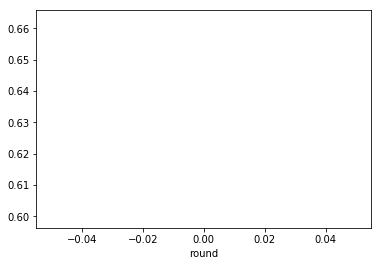

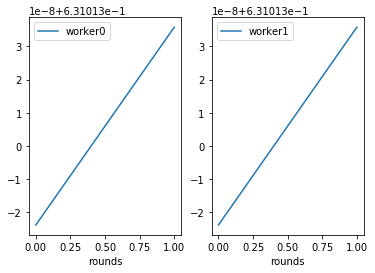

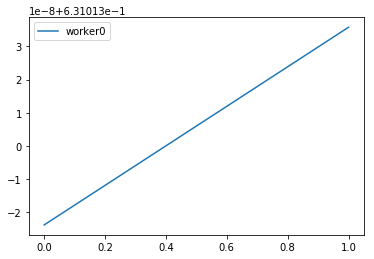

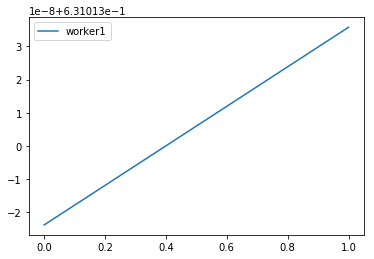

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");


fig, ax = plt.subplots(1, 2)
ax[0].plot(manager.worker_loss_histories[0], label="worker0")
ax[0].set_xlabel("rounds")
ax[1].plot(manager.worker_loss_histories[1], label="worker1")
ax[1].set_xlabel("rounds")
ax[0].legend()
ax[1].legend();

#fig, ax = plt.subplots()

print(len(manager.worker_loss_histories))

for i in range(len(manager.worker_loss_histories)):
    
    fig, ax = plt.subplots()
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

#ax.legend();

#TODO Get the plots correct